# Converting a Normal EPANET .inp File to a Simple Tank IWS File [1,2]
This notebook takes an input EPANET files with demands input normally as a CWS base demand and adds the necessary elements to convert it into a Simple Tank Method (STM) simulation  
For details on the STM method refer to [1,2]  
A simplified schematic of the modified demand node in STM is seen below:  
  
  
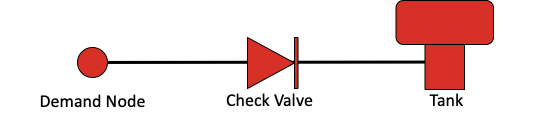


### First, we import the necessary libraries and packages
**WNTR** for building EPANET network models in Python  
**NUMPY & PANDAS** for data handling and processing  
**re** for searching and matching text in the .inp file using regular expressions

In [30]:
import wntr  
import numpy as np 
import pandas as pd
import re

### Specifying paths for simulation files and preprocessing the input
**Warning:** *Paths in this script (and the rest of this repo) are absolute unless running the network files provided within the repo*  
Input filename (with extensions) as string.  
For running the .inp files in this repository, you can use this relative path `"../Network-Files/Network X/"` where X is the network number 

In [31]:
# Replace with appropriate path and filename
directory='/Users/omaraliamer/Desktop/UofT/Publications/How to Model IWS/Github/IWS-Modelling-Methods-Repo/Network-Files/Network 3/'
filename='Network3_12hr_PDA.inp'
name_only=filename[0:-7]
print("Selected File: ",name_only)
abs_path=directory+filename

Selected File:  Network3_12hr_


### Necessary Assumptions Input
Converting a CWS demand-driven analysis into an IWS pressure-driven analysis requires some assumptions in all methods  
The resistance of the service connection between the demand node and the household (end-user) is uncertain and is modelled using two assumptions  
The **desired head (pressure)** is the pressure at the demand node at which (or above) the consumer can satisfy their full demand in the supply duration (or possible less)  
The **minimum head (pressure)** is the minimum pressure at the demand node required for flow to begin passing through the service connection  
These two assumptions dictate the flow-pressure relationship that determines the pressure-dependent flow through the service connection as follows:

$$ Q\, = \!Q_{des}\sqrt{\frac{H_{j}-H^{min}}{H^{des}-H^{min}}} \quad[1]$$ 
Where Q is the flow through the service connection, $Q_{des}$ is the desired (base) demand, $H_j$ is the head at the demand node $j$, $H^{min}$ is the minimum head, and $H^{des}$ is the desired head


In [32]:
desired_pressure=10     # Set the desired pressure
minimum_pressure=0      # Set the minimum pressure
pressure_diff=desired_pressure-minimum_pressure  

### Extracting information from the input file
To modify the .inp file, demand node IDs, elevations, x and y coordinates  
We use wntr to build the network model of the input file and use wntr's junctions module to extract the details of each node

In [33]:
demand_nodes=[]       # For storing list of nodes that have non-zero demands
desired_demands=[]    # For storing demand rates desired by each node for desired volume calculations
elevations=[]         # For storing elevations of demand nodes
xcoordinates=[]       # For storing x coordinates of demand nodes
ycoordinates=[]       # For storing y coordinates of demand nodes
all_nodes=[]          # For storing list of node ids of all nodes
all_elevations=[]     # For storing elevations of all nodes
## MAYBE SAVE ALL NODE IDS IN DATAFRAME WITH ELEVATION AND BASE DEMAND AND THEN FILTER DATA FRAME LATER FOR DEMAND NODES ONLY

# Creates a network model object using EPANET .inp file
network=wntr.network.WaterNetworkModel(abs_path)

# Iterates over the junction list in the Network object
for node in network.junctions():
    all_nodes.append(node[1].name)
    all_elevations.append(node[1].elevation)
    # For all nodes that have non-zero demands
    if node[1].base_demand != 0:
        # Record node ID (name), desired demand (base_demand) in CMS, elevations, x and y coordinates
        demand_nodes.append(node[1].name)
        desired_demands.append(node[1].base_demand)
        elevations.append(node[1].elevation)
        xcoordinates.append(node[1].coordinates[0])
        ycoordinates.append(node[1].coordinates[1])



# Get the supply duration in minutes (/60) as an integer
supply_duration=int(network.options.time.duration/60)

### Writing Tank Section
Each Simple Tank represents the demand volume of the respective demand node throughout the supply cycle  
The volume of each Simple Tank is calculated is:  
$$ V_{des}\,=\,Q_{des}\,(m^3/s)\,\times\,60\,(s/min)\,\times\,Supply\,Duration\,(min)$$  
Using the desired volume, and unifying tank height at 1 m (for ease of postprocessin), the diameter of the tank can be calculated as:  
$$D\,(m)\,=\sqrt{\frac{4V_{des}}{\pi}}$$

In [34]:
# Adds the phrase TankforNode to each node id and stores it as a tank id
tankids=['TankforNode'+str(id) for id in demand_nodes] 
# Calculate desired demand volumes and then calculates the diameters of the simple tanks
volumes=[demand* 60 * supply_duration for demand in desired_demands]
diameters_tanks=[round(np.sqrt(volume * 4 / np.pi),4) for volume in volumes]
# List of zeros for each tank to be used as the values for Initial Level, Minimum Level, and Minimum Volume 
zeros=[0.0000] *len(tankids)
# Sets Maximum levels for all tanks as 1
MaxLevel=[1.0000]*len(tankids)
# No Volume curve is assigned to any of the tanks
VolCurve=['    ']*len(tankids)
# Semicolons to end each tank line
semicolons=[';']*len(tankids)
# Assemble all lists into a dataframe where each row is the definition for one simple tank
tanks_section=pd.DataFrame(list(zip(tankids,elevations,zeros,zeros,MaxLevel,diameters_tanks,zeros,VolCurve,semicolons)))
# Exports the tank section as a list of strings where each entry is a line of the tanks section
tanks_section=tanks_section.to_string(header=False,index=False,col_space=10).splitlines()

### Writing Added Pipes
Similar to the tanks section, each field for the pipe entries is stored in a separate list  
The added pipes connect the created tanks to the original demand nodes and are responsible for simulating the pressure-dependent flow relationship  
The length of the pipe is calculated according to the required head flow relationship dictated by the minimum and desired pressure as:  
$$L=(H^{des}-H^{min})\frac{C^{1.852}D^{4.87}}{10.67Q_{des}^{1.852}}$$  
The diameter is unified at 0.05 m (50 mm)

In [35]:
# Adds the phrase PipeforNode to each node id and stores it as a pipe id
pipeids=['PipeforNode'+str(id) for id in demand_nodes]
# Calculates the length of each pipe to simulate the head-flow relationship
lengths=[round(pressure_diff*130**1.852*0.05**4.87/10.67/(demand)**1.852 , 4) for demand in desired_demands]
# Sets all diameters to 1 m (1000 mm)
diameters_pipes=[50]*len(pipeids)
# Sets all Hazen-Williams Coefficients as 130
hazen=[130]*len(pipeids)
# Sets all created pipes to work as Check Valved to prevent backflow
status=['CV']*len(pipeids)
# Assemble all lists into a dataframe where each row is the definition for one simple tank
pipes_addendum=pd.DataFrame(list(zip(pipeids,demand_nodes,tankids,lengths,diameters_pipes,hazen,zeros,status,semicolons)))
# Exports the pipe section as a list of strings where each entry is a line of the pipes section
pipes_addendum=pipes_addendum.to_string(header=False,index=False,col_space=10).splitlines()

### Writing Tank Coordinates
Each tank's coordinates are translated by a XX m in both x and y directions  
The coordinates of the tank nodes are merely for display and do not affect the simulation in any way

In [36]:
# Translates the tanks by a 100 m in both axes 
xcoordinates=[x+50 for x in xcoordinates]
ycoordinates=[y+50 for y in ycoordinates]

# Assemble all lists into a dataframe where each row is the coordinates for one simple tank
coordinates_add=pd.DataFrame(list(zip(tankids,xcoordinates,ycoordinates)))
# Exports the coordinate section as a list of strings where each entry is a line of the coordinates section
coordinates_add=coordinates_add.to_string(header=False,index=False,col_space=10).splitlines()

### Rewriting Base Demands
After creating the simple tanks, the base demands for all demand junctions has to be reset to zero

In [37]:
# List of zero base demands for all nodes
zerodemands=[0]*len(all_nodes)
# White space indicating no patterns
pattern=['     ']*len(all_nodes)
semicolons=[';']*len(all_nodes)
nodes=pd.DataFrame(list(zip(all_nodes,all_elevations,zerodemands,pattern,semicolons)))
nodes=nodes.to_string(header=False,index=False).splitlines()

### Writing the modified STM .inp File
We first read through the original .inp file to find the line positions of each of the sections  
Then each added or modified section is written into a new file and saved

In [38]:
# opens .inp file to read
file=open(abs_path,'r')
lines=[]            # list to store all lines in the .inp file
linecount=0         # Counter for the number of lines
junctions_marker=0  # To store the line number at which the junctions section starts
tanks_marker=0      # To store the line number at which the tanks section starts
pipes_marker=0      # To store the line number at which the pumps section starts
coords_marker=0     # To store the line number at which the vertices section starts

# Loops over each line in the input file 
for line in file:
    # Record the position of the phrase [JUNCTIONS] and add 2 to skip the header line
    if re.search('\[JUNCTIONS\]',line):
        junctions_marker=linecount+2
    # Record the position of the phrase [TANKS] and add 2 to skip the header line
    if re.search('\[TANKS\]',line):
        tanks_marker=linecount+2
     # Record the position of the phrase [PUMPS] and subtract 1 to add pipes to the end of the pipe section
    if re.search('\[PUMPS\]',line):
        pipes_marker=linecount-1
     # Record the position of the phrase [Vertices] and subtract 1 to add Tank cooridnates to the end of the coordinates section
    if re.search('\[VERTICES\]',line):
        coords_marker=linecount-1
    linecount+=1
    # Store all lines in a list
    lines.append(line)
file.close()

# Translate the pipes marker by the length of the tank section that will be added before it (as it will displace all subsequent lines)
pipes_marker+=len(tanks_section)
# Translate the coordinates marker by the length of the added tanks and pipes
coords_marker+=len(tanks_section)+len(pipes_addendum)

# Inserts the created sections in their appropriate location in the list of lines
lines[junctions_marker:junctions_marker+len(nodes)]=nodes
lines[tanks_marker:tanks_marker]=tanks_section
lines[pipes_marker:pipes_marker]=pipes_addendum
lines[coords_marker:coords_marker]=coordinates_add

# Opens a new file in the same directory to write the modified network .inp file in
file=open(directory+name_only+'STM.inp','w')
c=0     #line counter

# All lines added by this script are missing a new line character at the end, the conditional statements below add the new line character for these lines only and writes all lines to the file
for line in lines:
    if c>=junctions_marker and c<=junctions_marker+len(nodes):
        file.write(line+'\n')
    elif c>=tanks_marker and c<=tanks_marker+len(tanks_section):
        file.write(line+'\n')
    elif c>=pipes_marker and c<=pipes_marker+len(pipes_addendum):
        file.write(line+'\n')
    elif c>=coords_marker and c<=coords_marker+len(coordinates_add):
        file.write(line+'\n')
    else: file.write(line)    
    c+=1
file.close()


### References:
##### [1] A. Batterman and S. Macke, “A Strategy to Reduce Technical Water Losses for Intermittent Water Supply Systems,” Fachhochschule Nordostniedersachsen, 2001. Accessed: Feb. 14, 2022. [Online]. Available: http://sdteffen.de/diplom/thesis.pdf
##### [2] D. D. J. Taylor, A. H. Slocum, and A. J. Whittle, “Demand Satisfaction as a Framework for Understanding Intermittent Water Supply Systems,” Water Resources Research, vol. 55, no. 7, pp. 5217–5237, 2019, doi: 10.1029/2018WR024124.
##### [3] B. M. Janet Wagner, U. Shamir, and D. H. Marks, “WATER DISTRIBUTION RELIABILITY: SIMULATION METHODS.”